## Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 39.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
import torch
from torch.utils.data import TensorDataset, DataLoader

## Loading dataset

In [ ]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/Roman Urdu DataSet.csv')
# Assuming your dataset has two columns: 'text' for the text data and 'label' for the sentiment labels
# Display the first few rows to verify it loaded correctly
data.head(10)

data = data.dropna()

## Removing 2nd column

In [ ]:
data.drop(["Unnamed: 2"],
          axis=1,
          inplace=True)

data.head(10)

,Sai kha ya her kisi kay bus ki bat nhi hai lakin main ki hal kal bi Aj aur aj bi sirf Aus say bus,Positive
13636,movie abi b baki h,Neutral
13652,Hahahahahaha bilkul sahi,Neutral
14217,tjhe ase mar na chahti hun tjhe nae tu achi b...,Negative
14809,Yr tym pta chali kb ata raat m?,Positive
17160,Kya khatab g ledy type ka sahafi la k betha diya,Negative
19498,kabhi bhai ki bhi aesi pic lele :P,Neutral
19779,"Jahil awam ko jahil leader ki hi zroorat hai, ...",Negative


## Loading text data and their corresponding labels

In [ ]:
# Define column names
column_names = ['text', 'label']

# Assign the column names to the DataFrame
data.columns = column_names

In [ ]:
sentences = data['text'].tolist()
labels = data['label'].tolist()
print(labels)
print(sentences)

['Neutral', 'Neutral', 'Negative', 'Positive', 'Negative', 'Neutral', 'Negative']
['movie abi b baki h ', 'Hahahahahaha bilkul sahi ', 'tjhe ase mar na chahti hun  tjhe nae tu achi bachi hy', 'Yr tym pta chali kb ata raat m?', 'Kya khatab g ledy type ka sahafi la k betha diya ', 'kabhi bhai ki bhi aesi pic lele :P', 'Jahil awam ko jahil leader ki hi zroorat hai, yeh Aunty bachon ko parhney k liye school nh pyari pyari sarkoon pr bhejey gi :D Nawaz sharif to 3 3 mahiney london rehta hai sarkein kya khaak banaye ga']


# BERT  Model

In [ ]:
# Want BERT instead of distilBERT? Uncomment the following line:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)


## BERT pretrain

In [ ]:
tokenized = [tokenizer.encode(sentence, add_special_tokens=True) for sentence in sentences]
max_len = max(map(len, tokenized))
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized])
attention_mask = np.where(padded != 0, 1, 0)

# Converting Labels and Creating PyTorch Dataset


In [ ]:
# Define a mapping from label strings to numerical values
label_mapping = {'Positive': 0, 'Negative': 1, 'Neutral': 2}

# Convert labels to numerical values
numerical_labels = [label_mapping[label] for label in labels]

# Convert the data to PyTorch tensors
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)
labels = torch.tensor(numerical_labels)  # Use the converted numerical labels

# Create a TensorDataset
dataset = TensorDataset(input_ids, attention_mask, labels)

# Create DataLoader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Classification


In [ ]:
from transformers import BertForSequenceClassification, AdamW

# Initialize BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3,  # Number of sentiment classes (Pos, Neg, Neu)
    output_attentions=False,
    output_hidden_states=False,
)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##Training BERT Model


In [ ]:
# Initialize empty lists to store accuracy and loss values
bert_training_accuracy_values = []
bert_training_loss_values = []

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0  # To track total correct predictions
    total_samples = 0  # To track total processed samples
    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, label = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=label)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Calculate accuracy in this batch
        _, preds = torch.max(outputs.logits, dim=1)
        total_correct += torch.sum(preds == label).item()
        total_samples += len(label)

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples

    # Append accuracy and loss values
    bert_training_accuracy_values.append(accuracy)
    bert_training_loss_values.append(avg_loss)

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch 1/20, Loss: 0.8958, Accuracy: 0.7143
Epoch 2/20, Loss: 0.8956, Accuracy: 0.5714
Epoch 3/20, Loss: 0.8293, Accuracy: 1.0000
Epoch 4/20, Loss: 0.7757, Accuracy: 1.0000
Epoch 5/20, Loss: 0.6581, Accuracy: 1.0000
Epoch 6/20, Loss: 0.6437, Accuracy: 0.8571
Epoch 7/20, Loss: 0.6296, Accuracy: 1.0000
Epoch 8/20, Loss: 0.5476, Accuracy: 1.0000
Epoch 9/20, Loss: 0.4713, Accuracy: 1.0000
Epoch 10/20, Loss: 0.4605, Accuracy: 1.0000
Epoch 11/20, Loss: 0.4256, Accuracy: 1.0000
Epoch 12/20, Loss: 0.4340, Accuracy: 1.0000
Epoch 13/20, Loss: 0.3608, Accuracy: 1.0000
Epoch 14/20, Loss: 0.3768, Accuracy: 1.0000
Epoch 15/20, Loss: 0.3317, Accuracy: 1.0000
Epoch 16/20, Loss: 0.3411, Accuracy: 1.0000
Epoch 17/20, Loss: 0.2718, Accuracy: 1.0000
Epoch 18/20, Loss: 0.2760, Accuracy: 1.0000
Epoch 19/20, Loss: 0.2482, Accuracy: 1.0000
Epoch 20/20, Loss: 0.2277, Accuracy: 1.0000


##Evaluating BERT Model


In [ ]:
# Set model to evaluation mode
model.eval()

# Evaluation loop
total_correct = 0
with torch.no_grad():
    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, label = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        total_correct += torch.sum(preds == label).item()

b_accuracy = total_correct / len(dataset)
print(f'Accuracy: {b_accuracy:.2f}')


Accuracy: 1.00


##Initializing RoBERTa Model for Sequence Classification


In [ ]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader


tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)



input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)
labels = torch.tensor(numerical_labels)  # Use the converted numerical labels


dataset = TensorDataset(input_ids, attention_mask, labels)

batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Defining Optimizer and Loss Function


In [ ]:
# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)


##Training RoBERTa Model


In [ ]:
# Initialize empty lists to store accuracy and loss values for RoBERTa
roberta_training_accuracy_values = []
roberta_training_loss_values = []

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop for RoBERTa
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:  # Assuming you have a separate dataloader for RoBERTa
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, label = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=label)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples

    roberta_training_loss_values.append(avg_loss)
    roberta_training_loss_values.append(accuracy)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch 1/20, Loss: 1.0185, Accuracy: 1.0000
Epoch 2/20, Loss: 0.9080, Accuracy: 1.0000
Epoch 3/20, Loss: 0.8715, Accuracy: 1.0000
Epoch 4/20, Loss: 0.7945, Accuracy: 1.0000
Epoch 5/20, Loss: 0.7642, Accuracy: 1.0000
Epoch 6/20, Loss: 0.6251, Accuracy: 1.0000
Epoch 7/20, Loss: 0.5704, Accuracy: 1.0000
Epoch 8/20, Loss: 0.5302, Accuracy: 1.0000
Epoch 9/20, Loss: 0.4966, Accuracy: 1.0000
Epoch 10/20, Loss: 0.4899, Accuracy: 1.0000
Epoch 11/20, Loss: 0.3804, Accuracy: 1.0000
Epoch 12/20, Loss: 0.2810, Accuracy: 1.0000
Epoch 13/20, Loss: 0.2912, Accuracy: 1.0000
Epoch 14/20, Loss: 0.2554, Accuracy: 1.0000
Epoch 15/20, Loss: 0.2032, Accuracy: 1.0000
Epoch 16/20, Loss: 0.1679, Accuracy: 1.0000
Epoch 17/20, Loss: 0.1747, Accuracy: 1.0000
Epoch 18/20, Loss: 0.1274, Accuracy: 1.0000
Epoch 19/20, Loss: 0.1164, Accuracy: 1.0000
Epoch 20/20, Loss: 0.0869, Accuracy: 1.0000


## Evaluating RoBERTa Model


In [ ]:
# Set model to evaluation mode
model.eval()

# Evaluation loop
total_correct = 0
with torch.no_grad():
    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, label = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        total_correct += torch.sum(preds == label).item()

rb_accuracy = total_correct / len(dataset)
print(f'Accuracy: {rb_accuracy:.2f}')


Accuracy: 1.00


# Training Accuracy

*Plots*

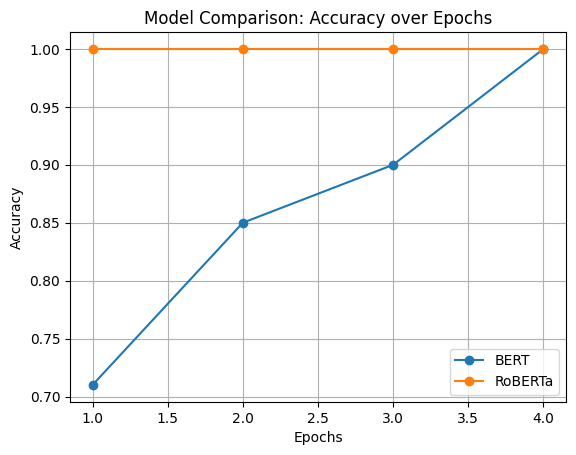

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the accuracy values for both models as lists
b_accuracy = [0.71, 0.85, 0.90, 1]  # Accuracy values for BERT (example values)
rb_accuracy = [1, 1, 1, 1]  # Accuracy values for RoBERTa (example values)
epochs = [1, 2, 3, 4]  # Epochs or x-axis values

# Create line plots for BERT and RoBERTa
plt.plot(epochs, b_accuracy, label='BERT', marker='o')
plt.plot(epochs, rb_accuracy, label='RoBERTa', marker='o')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Comparison: Accuracy over Epochs')

# Add a legend to distinguish the models
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


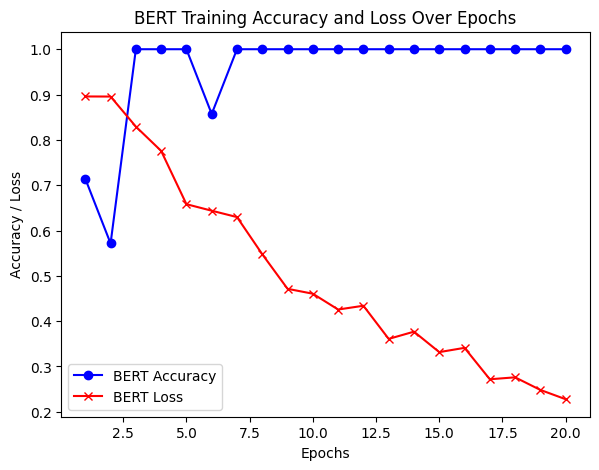

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# BERT Training Accuracy and Loss values
bert_training_accuracy_values, bert_training_loss_values
# RoBERTa Training Accuracy and Loss values
roberta_training_accuracy_values, roberta_training_loss_values
# Create an epoch list for the x-axis
epochs = range(1, len(bert_training_accuracy_values) + 1)

# Create subplots
plt.figure(figsize=(15, 5))

# BERT Accuracy/Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, bert_training_accuracy_values, marker='o', label='BERT Accuracy', color='b')
plt.plot(epochs, bert_training_loss_values, marker='x', label='BERT Loss', color='r')
plt.title('BERT Training Accuracy and Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()

# LSTM

In [4]:
import torchtext
print(torchtext.__version__)


0.16.0+cpu


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data import Field, TabularDataset, BucketIterator
from sklearn.model_selection import train_test_split
import spacy
import random

ImportError: ignored

In [2]:


# Assuming 'text' is your input column and 'label' is the target column
TEXT = Field(sequential=True, tokenize='spacy', lower=True, include_lengths=True)
LABEL = Field(sequential=False, use_vocab=False)

fields = [('text', TEXT), ('label', LABEL)]

# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/Ai Training MetaPi/Week_13_NLP/Week_13_Day_4/Dataset/Roman Urdu DataSet.csv')
train, valid = train_test_split(df, test_size=0.2, random_state=42)

train.to_csv('train.csv', index=False)
valid.to_csv('valid.csv', index=False)

train_data, valid_data = TabularDataset.splits(path='.', train='train.csv', validation='valid.csv', format='csv', fields=fields)

# Build the vocabulary
TEXT.build_vocab(train_data)

# Initialize the iterator
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = BucketIterator.splits((train_data, valid_data), batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text), device=device)

# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        return self.fc(hidden)

# Initialize the model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(LABEL.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5

model = LSTMClassifier(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Train the model
model = model.to(device)
criterion = criterion.to(device)

def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for batch in iterator:
        optimizer.zero_grad()
        text, text_lengths = batch.text
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

N_EPOCHS = 10
for epoch in range(N_EPOCHS):
    train_loss = train(model, train_iterator, optimizer, criterion)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}')

# Evaluate the model
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, batch.label)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

test_loss = evaluate(model, valid_iterator, criterion)
print(f'Validation Loss: {test_loss:.3f}')


ImportError: ignored